In [1]:
import lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import MultipleLocator

In [3]:
# === Helper functions ===
def get_gamma_ray_column(las):
    candidates = ["GR", "GRC", "GRD", "SGR", "GAM", "GAPI"]
    for curve in las.curves:
        if curve.mnemonic.upper() in candidates:
            return curve.mnemonic
        if "gamma" in curve.descr.lower():
            return curve.mnemonic
    return None

def get_density_log_column(las):
    candidates = ["DEN", "RHOZ", "RHOB", "DENS", "ZDEN", "RHOD", "RHO", "LSD", "SSD", "RHO8", "RHOI"]
    for curve in las.curves:
        if curve.mnemonic.upper() in candidates:
            return curve.mnemonic
        if "density" in curve.descr.lower():
            return curve.mnemonic
    return None

In [5]:
# === Load Formation Tops from Excel ===
tops_df = pd.read_excel(r"C:\Users\JessGodfrey\welldata\ODwells_Tops.xlsx")
tops_df.columns = [col.lower() for col in tops_df.columns]

# Build dictionary {well_name_lowercase: [ {name, depth}, ... ]}
tops_by_well = {}
for _, row in tops_df.iterrows():
    well = str(row['well name']).strip().lower()
    tops_by_well.setdefault(well, []).append({"name": row["formation top"], "depth": row["depth (m)"]})

# === Create color map for formation tops ===
all_formations = sorted(set(top["name"] for tops in tops_by_well.values() for top in tops))
cmap = plt.get_cmap('tab20')
color_map = {formation: cmap(i % 20) for i, formation in enumerate(all_formations)}

In [19]:
# === Load LAS Files ===
# === Load LAS Files ===
las_files = [
    "welldata/OD020F.las",
    "welldata/OD021F.las",
    "welldata/OD022FA.las"
]

well_dfs = []
well_names = []
depth_min, depth_max = np.inf, -np.inf

for file in las_files:
    try:
        las = lasio.read(file)
        gr_col = get_gamma_ray_column(las)
        den_col = get_density_log_column(las)

        if gr_col is None or den_col is None:
            print(f"Skipping {file}: missing GR or DEN")
            continue

        df = las.df()
        df["DEPTH"] = df.index
        df = df.replace(-999.25, np.nan).dropna(subset=[gr_col, den_col])
        df = df.reset_index(drop=True)
        df.rename(columns={gr_col: "GRPD", den_col: "DEN"}, inplace=True)

        depth_min = min(depth_min, df["DEPTH"].min())
        depth_max = max(depth_max, df["DEPTH"].max())

        well_dfs.append(df)
        well_names.append(os.path.basename(file))

    except Exception as e:
        print(f"Error reading {file}: {e}")

# ✅ Make sure this line runs AFTER loading all wells
n_wells = len(well_dfs)


# === Plot Function with Formation Tops ===
def plot_logs(dmin, dmax):
    fig, axs = plt.subplots(
        ncols=n_wells * 2,
        figsize=(1.5 * n_wells * 2, 36),
        sharey=True
    )
    fig.subplots_adjust(bottom=0.1)

    if n_wells == 1:
        axs = [axs]

    for i, (df, name) in enumerate(zip(well_dfs, well_names)):
        df_filtered = df[(df["DEPTH"] >= dmin) & (df["DEPTH"] <= dmax)]
        df_filtered = df_filtered.iloc[::5]  # Subsample for performance

        depth = df_filtered["DEPTH"].values
        grpd = df_filtered["GRPD"].values
        den = df_filtered["DEN"].values

        ax_gr = axs[i * 2]
        ax_den = axs[i * 2 + 1]

        # === GR Track ===
        grpd_clipped = np.clip(grpd, 0, 200)
        norm = plt.Normalize(0, 200)
        cmap = plt.cm.YlOrBr
        colors = cmap(norm(grpd_clipped))

        for j in range(len(df_filtered) - 1):
            ax_gr.fill_betweenx(
                [depth[j], depth[j + 1]],
                [grpd[j], grpd[j + 1]],
                200,
                color=colors[j]
            )
        ax_gr.plot(grpd, depth, color='black', linewidth=0.5)
        ax_gr.set_xlim(0, 200)
        ax_gr.set_ylim(dmax, dmin)
        ax_gr.set_title(f"{name}\nGRPD (API)", fontsize=10)
        ax_gr.xaxis.set_label_position('top')
        ax_gr.tick_params(axis='x', labeltop=True, labelbottom=False)
        ax_gr.yaxis.set_major_locator(MultipleLocator(100))
        ax_gr.yaxis.set_minor_locator(MultipleLocator(20))
        ax_gr.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

        # === DEN Track ===
        ax_den.plot(den, depth, color='black', linewidth=0.5)
        ax_den.axvline(x=1.75, color='black', linestyle='--', linewidth=0.75)
        for j in range(len(den) - 1):
            if den[j] < 1.75 and den[j + 1] < 1.75:
                ax_den.fill_betweenx(
                    [depth[j], depth[j + 1]],
                    [den[j], den[j + 1]],
                    1.75,
                    color='black'
                )
        ax_den.set_xlim(0.95, 2.95)
        ax_den.set_title(f"{name}\nDEN (g/cc)", fontsize=10)
        ax_den.xaxis.set_label_position('top')
        ax_den.tick_params(axis='x', labeltop=True, labelbottom=False)
        ax_den.yaxis.set_major_locator(MultipleLocator(100))
        ax_den.yaxis.set_minor_locator(MultipleLocator(20))
        ax_den.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

        # === Formation Tops ===
        well_key = name.split(".")[0].lower()
        tops = tops_by_well.get(well_key, [])
        for top in tops:
            if dmin <= top["depth"] <= dmax:
                color = color_map.get(top["name"], "blue")
                for ax in (ax_gr, ax_den):
                    ax.axhline(
                        y=top["depth"],
                        color=color,
                        linestyle='--',
                        linewidth=1.5,
                        alpha=0.8
                    )

    return fig


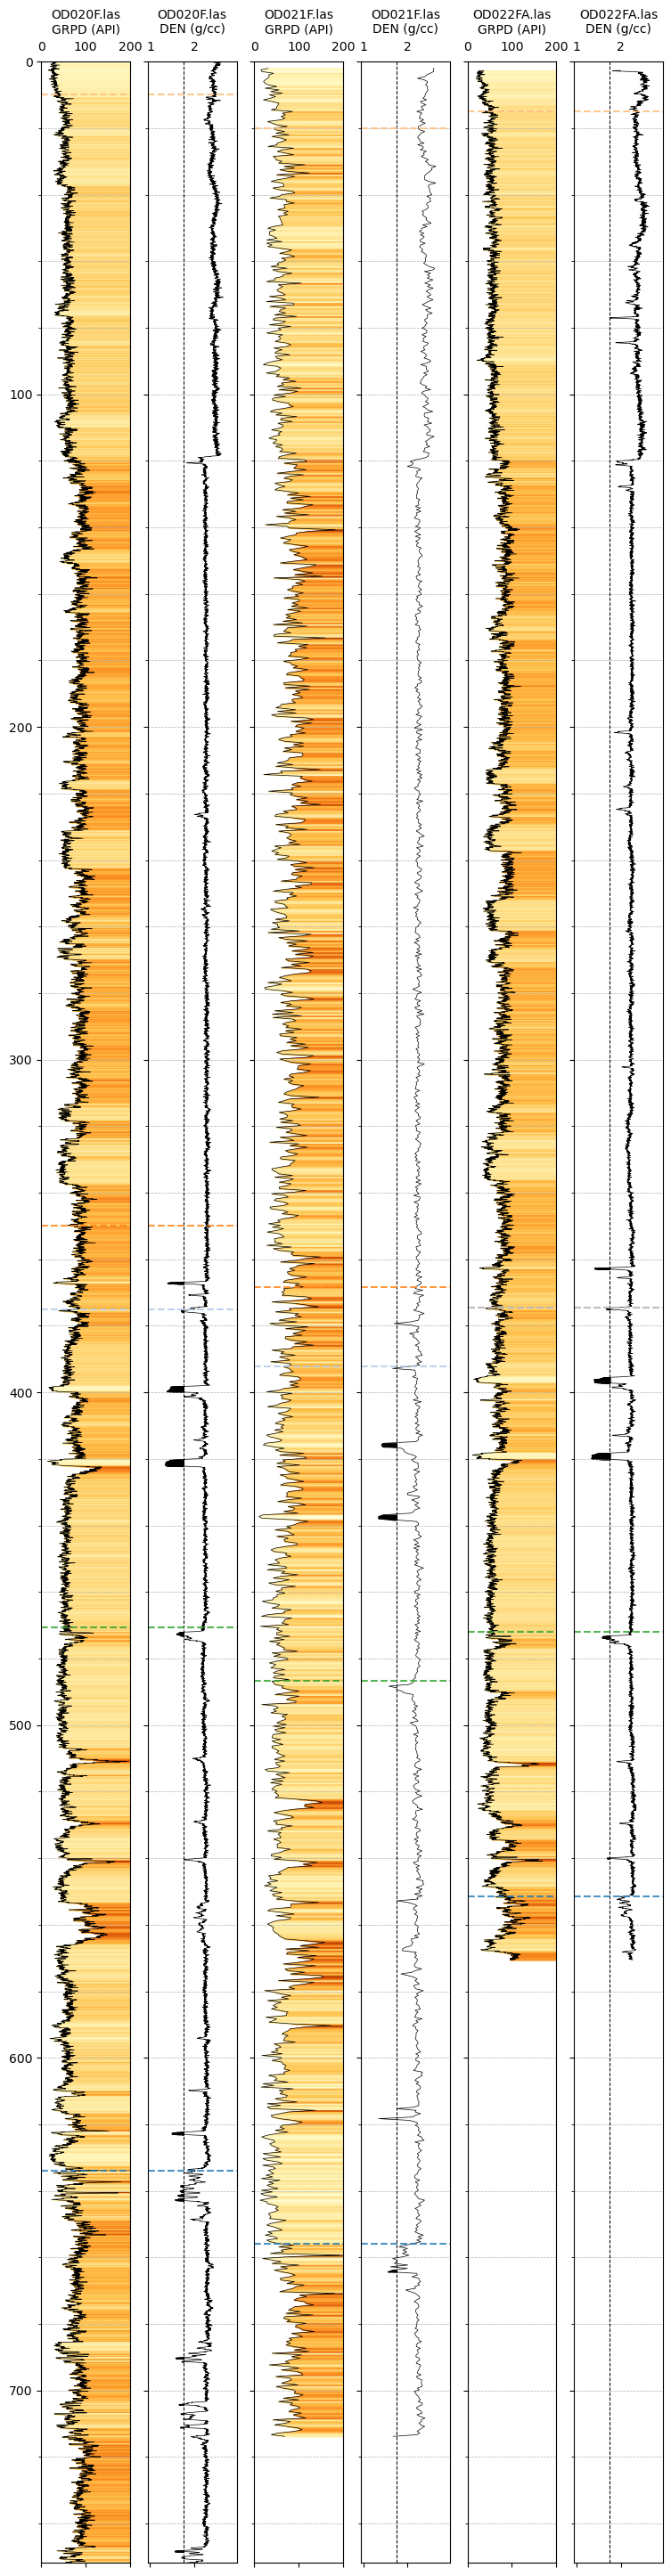

In [20]:
# === Final Plot ===
fig = plot_logs(depth_min, depth_max)
plt.show()